<a href="https://colab.research.google.com/github/AARYA2k04/risk-stratification-for-ALS-with-biomarkers-and-vital-signs/blob/main/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy matplotlib lifelines tensorflow scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=3aa59667f33adbfe60f12c8a05b73cf4dcdaae10c1f473d2eef0f95a7516c351
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter, statistics
import matplotlib.pyplot as plt

# Load the preprocessed dataset
file_path = '/content/preprocessed_data (1).csv'
data = pd.read_csv(file_path)


clean dataset

 Kaplan-Meier Survival Analysis
Analyze survival probabilities over time and stratify by a biomarker (e.g., Albumin).

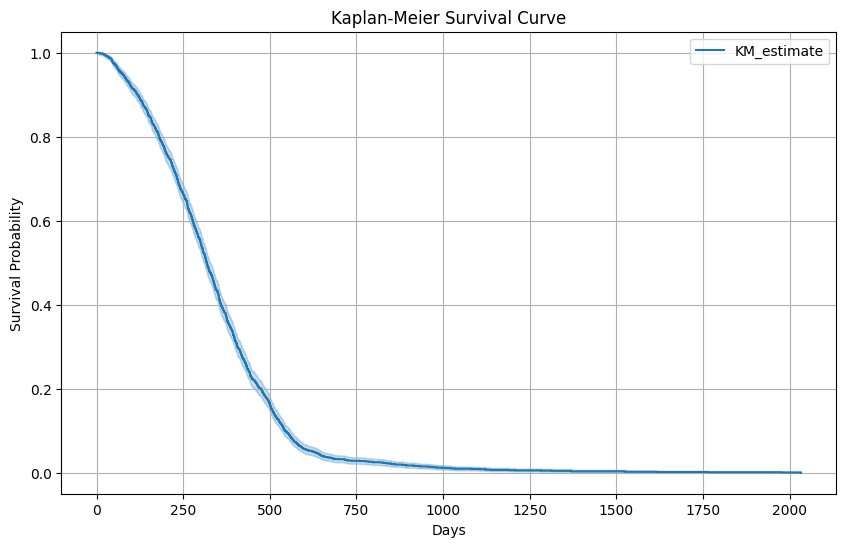

In [ ]:
# Step 1: Kaplan-Meier Survival Analysis
# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=data['Death_Days'], event_observed=data['Subject_Died'])

# Plot the survival function
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()

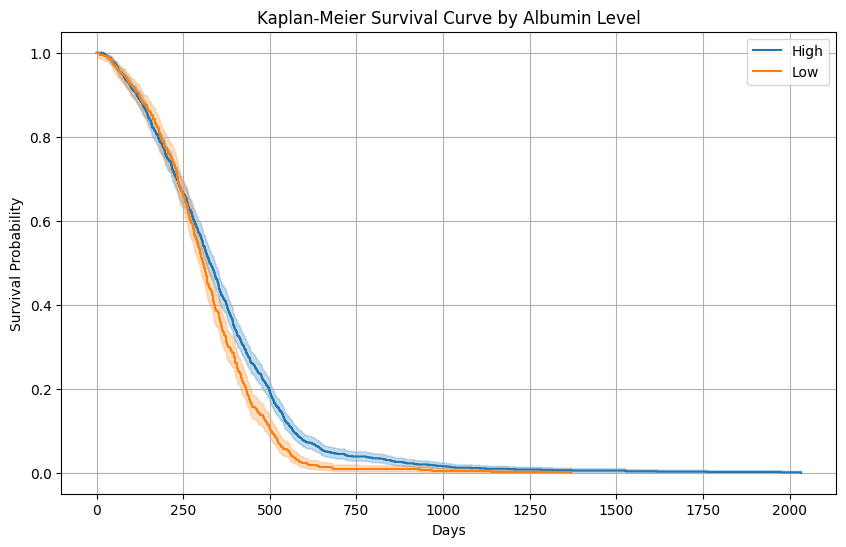

Log-Rank Test p-value: 9.850748763056957e-07


In [ ]:
# Step 2: Stratify survival curves by a biomarker (e.g., Albumin)
# Create a high/low stratification based on the median
data['Albumin_High_Low'] = np.where(data['Albumin'] >= data['Albumin'].median(), 'High', 'Low')

# Fit and plot survival curves for each group
plt.figure(figsize=(10, 6))
for group in data['Albumin_High_Low'].unique():
    group_data = data[data['Albumin_High_Low'] == group]
    kmf.fit(durations=group_data['Death_Days'], event_observed=group_data['Subject_Died'], label=group)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Albumin Level')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()

# Perform Log-Rank Test between groups
high_group = data[data['Albumin_High_Low'] == 'High']
low_group = data[data['Albumin_High_Low'] == 'Low']
results = statistics.logrank_test(high_group['Death_Days'], low_group['Death_Days'],
                                   event_observed_A=high_group['Subject_Died'],
                                   event_observed_B=low_group['Subject_Died'])
print("Log-Rank Test p-value:", results.p_value)

 Cox Proportional Hazards Model
Identify significant biomarkers related to survival.

                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
Albumin            -0.040834   0.959988  0.006264       -0.053112   
Bilirubin_(Total)   0.016560   1.016698  0.004697        0.007354   
C-Reactive_Protein -0.004730   0.995281  0.014465       -0.033081   
Creatinine          0.003576   1.003582  0.001177        0.001270   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
Albumin                  -0.028557             0.948274             0.971847   
Bilirubin_(Total)         0.025766             1.007381             1.026101   
C-Reactive_Protein        0.023621             0.967460             1.023902   
Creatinine                0.005882             1.001271             1.005899   

                    cmp to         z             p   -log2(p)  
covariate                               

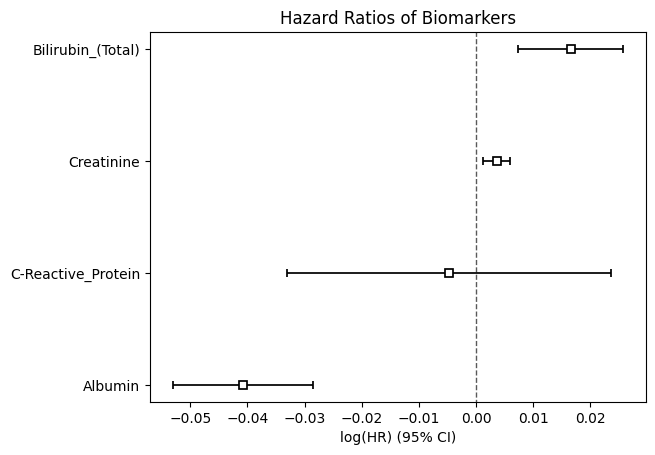

In [ ]:
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Step 1: Select columns for Cox regression (excluding 'Hemoglobin')
cox_data = data[['Death_Days', 'Subject_Died', 'Albumin','Bilirubin_(Total)','C-Reactive_Protein', 'Creatinine']]

# Step 2: Handle missing values (if any)
cox_data = cox_data.dropna()

# Step 3: Initialize Cox Proportional Hazards model
cph = CoxPHFitter()

# Step 4: Fit the model
cph.fit(cox_data, duration_col='Death_Days', event_col='Subject_Died')

# Step 5: Display summary of the model
print(cph.summary)

# Step 6: Plot the hazard ratios
cph.plot()
plt.title('Hazard Ratios of Biomarkers')
plt.show()


# Risk Score and Kaplan-Meier for Risk Groups


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1801 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic    p  -log2(p)
Albumin            km              4.73 0.03      5.08
                   rank            4.71 0.03      5.06
Bilirubin_(Total)  km              0.66 0.42      1.26
                   rank            0.66 0.42      1.26
C-Reactive_Protein km              0.32 0.57      0.81
                   rank            0.33 0.57      0.82
Creatinine         km              3.74 0.05      4.23
                   rank            3.72 0.05      4.22



1. Variable 'Albumin' failed the non-proportional test: p-value is 0.0296.

   Advice 1: the functional form of the variable 'Albumin' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Albumin' using pd.cut, and then specify it in
`strata=['Albumin', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Creatinine' failed the non-proportional test: p-value is 0.0532.

   Advice 1: the functional form of the variable 'Creatinine' might be incorrect. That is, there may
be non-linear te

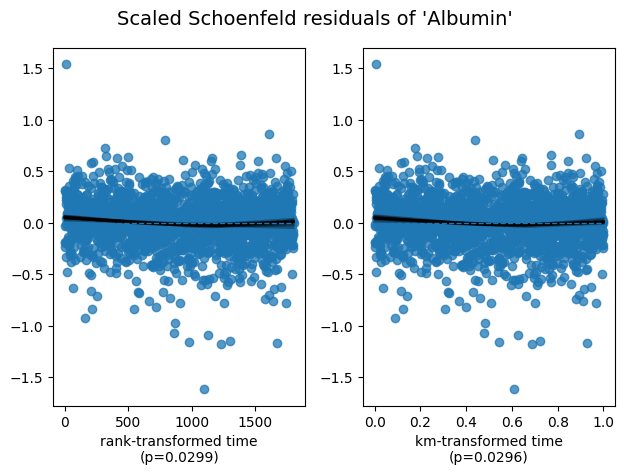

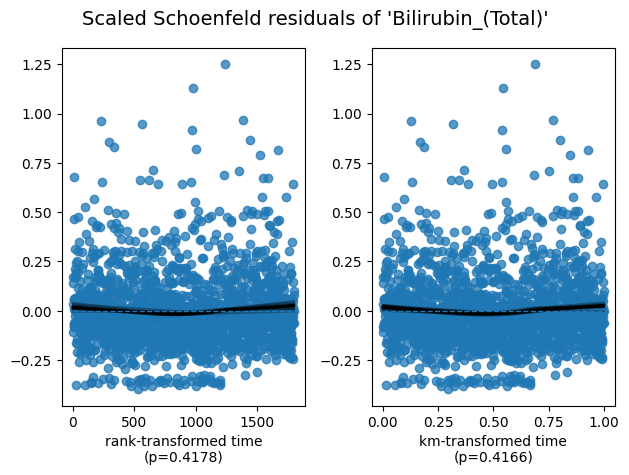

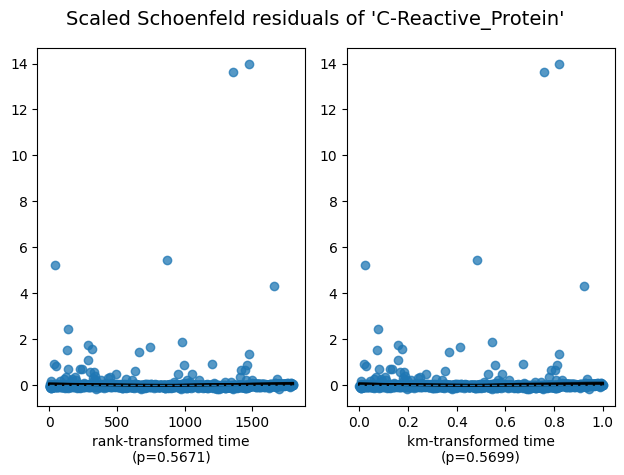

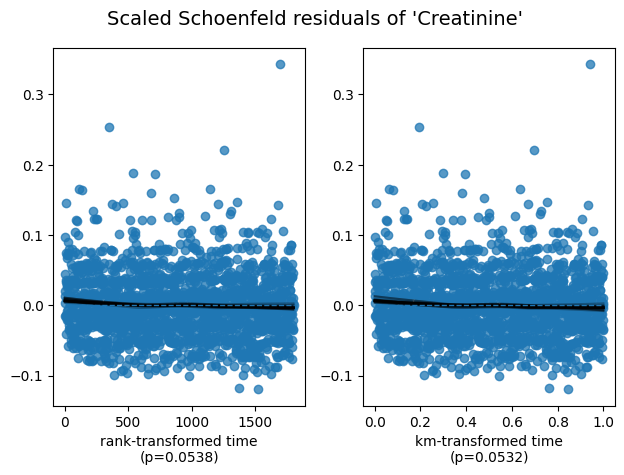

In [ ]:


# Step 5: Identify Significant Biomarkers
# Filter biomarkers with significant p-values
significant_biomarkers = cph.summary[cph.summary['p'] < 0.05]
print("\nSignificant Biomarkers:\n")
print(significant_biomarkers)

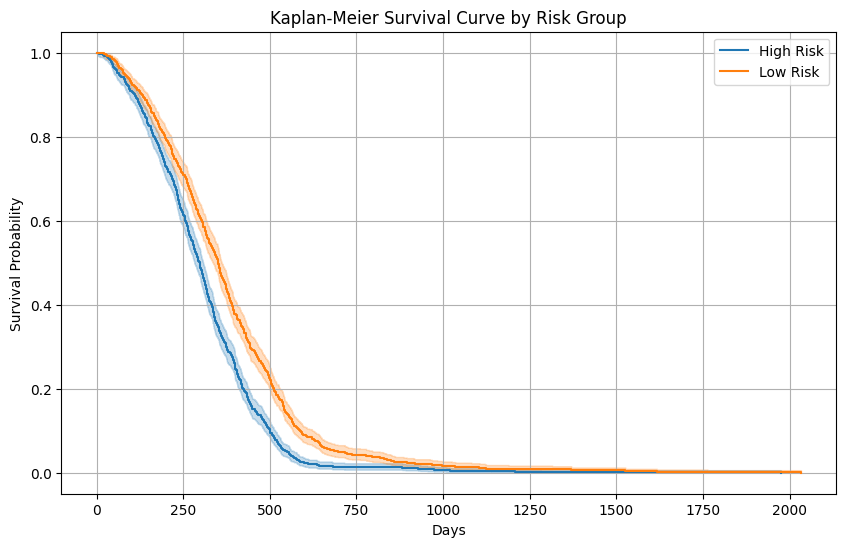

In [ ]:
# Compute risk scores using significant biomarkers
if not significant_biomarkers.empty:
    significant_features = significant_biomarkers.index.tolist()
    data['Risk_Score'] = np.dot(data[significant_features], significant_biomarkers['coef'])

    # Stratify into High Risk and Low Risk groups
    data['Risk_Group'] = np.where(data['Risk_Score'] >= data['Risk_Score'].median(), 'High Risk', 'Low Risk')

    # Kaplan-Meier survival curves for risk groups
    plt.figure(figsize=(10, 6))
    for group in data['Risk_Group'].unique():
        group_data = data[data['Risk_Group'] == group]
        kmf.fit(durations=group_data['Death_Days'], event_observed=group_data['Subject_Died'], label=group)
        kmf.plot_survival_function()

    plt.title('Kaplan-Meier Survival Curve by Risk Group')
    plt.xlabel('Days')
    plt.ylabel('Survival Probability')
    plt.grid()
    plt.show()


 Building a Dense Neural Network for Risk Classification
Train a neural network to classify patients into high-risk or low-risk groups.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare features and labels
X = data[['Albumin', 'Bilirubin_(Total)', 'C-Reactive_Protein', 'Creatinine']]
y = (data['Risk_Group'] == 'High Risk').astype(int)  # Encode High Risk as 1, Low Risk as 0

# Handle missing values
X = X.fillna(X.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Model Training:

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

# Build the model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7193 - loss: 0.6107 - val_accuracy: 0.9826 - val_loss: 0.3509
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9609 - loss: 0.3115 - val_accuracy: 0.9931 - val_loss: 0.1459
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 0.1548 - val_accuracy: 0.9965 - val_loss: 0.0762
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 0.0908 - val_accuracy: 0.9965 - val_loss: 0.0545
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0673 - val_accuracy: 1.0000 - val_loss: 0.0428
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0498 - val_accuracy: 1.0000 - val_loss: 0.0357
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0451 - val_accuracy: 0.9965 - val_loss: 0.0318
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0409 - val_accuracy: 0.9965 - val_loss: 0.0

Model Evaluation
Evaluate the model using classification metrics.

In [ ]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       176
           1       0.98      0.99      0.99       185

    accuracy                           0.99       361
   macro avg       0.99      0.99      0.99       361
weighted avg       0.99      0.99      0.99       361



Save and Export Results

In [ ]:
# Save the processed dataset with risk scores and groups
data.to_csv('final_results_with_risk_scores.csv', index=False)
print("Results saved to final_results_with_risk_scores.csv")


Results saved to final_results_with_risk_scores.csv
